### Step 1. Importing and preprocessing the dataset

In [2]:
import os # helps to read images froma a directory
import pandas as pd 
import numpy as np 
from tensorflow.keras.preprocessing.image import ImageDataGenerator # loading and processing images for Deep Learning
from tensorflow.keras.models import Sequential # to build a Deep Learning model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # layers for the Deep Learning model
from tensorflow.keras.optimizers import Adam # optimizer for training the model
from sklearn.metrics import classification_report, confusion_matrix # evaluating the model

In [3]:
train_dir = 'data/chest_xray/train'
categories = ['NORMAL', 'PNEUMONIA']
filepaths = []
labels = []

In [4]:
# Loop through each category and get file paths and labels
for category in categories:
    folder = os.path.join(train_dir, category)
    for fname in os.listdir(folder):
        filepaths.append(f"{category}/{fname}")
        labels.append(category)

In [5]:
df = pd.DataFrame({'Filename': filepaths, 'Label': labels})

In [6]:
# rescaling pixel values (lower it) and setting aside validation data (80% training and 20% validation)
# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,      # Small rotations only (lungs should stay vertical)
    zoom_range=0.1,         # Zoom in slightly
    width_shift_range=0.05,  # Shift left/right
    height_shift_range=0.05, # Shift up/down
    horizontal_flip=True,   # Lungs are roughly symmetrical
    validation_split=0.2    # Keep your split
)

In [7]:
# Loading training data from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='Filename',
    y_col='Label',
    subset='training',
    batch_size=64, # processing 32 images at a time
    seed=42, # starting point for random operations
    shuffle=True, # shuffling data before the training
    class_mode='binary', # binary classification (NORMAL vs PNEUMONIA)
    target_size=(150, 150) # resizing images to 150x150 pixels
)

Found 4173 validated image filenames belonging to 2 classes.


In [8]:
# validation data from dataframe
valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='Filename',
    y_col='Label',
    subset='validation',
    batch_size=64, # processing 32 images at a time
    seed=42, # starting point for random operations
    shuffle=True, # shuffling data before the training
    class_mode='binary', # binary classification (NORMAL vs PNEUMONIA)
    target_size=(150, 150) # resizing images to 150x150 pixels
)

Found 1043 validated image filenames belonging to 2 classes.


### Step 2. Building a CNN model (Convolution, ReLU, Pooling, Dense Layers)

In [9]:
''' Building the CNN model
    Sequential model adds one layer after another in sequence, like a pipeline. Each layer transforms the data in some way.
    Conv2D layer applies convolution operation to extract features from images using filters/kernels.
    MaxPooling2D layer reduces the spatial dimensions (width and height) of the feature maps, retaining important information while reducing computational load.
    Flatten layer converts the 2D feature maps into a 1D vector, preparing it for the fully connected layers.
    Dropout layer randomly sets a fraction of input units to 0 during training to prevent overfitting.
    Dense layer is a fully connected layer where each neuron is connected to every neuron in the previous layer.
    The final Dense layer with a sigmoid activation function outputs a probability score between 0 and 1 for binary classification (NORMAL vs PNEUMONIA).
'''

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)), # finding the patterns in the images; 3 channels for RGB.
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu'), # 64 filters to learn more complex features
    MaxPooling2D((2, 2)), 
    Conv2D(128, (3, 3), activation='relu'), # 128 filters for even more complex features
    MaxPooling2D((2, 2)),
    # Dropout(0.2), # added extra Dropout layer to reduce overfitting
    Flatten(), 
    Dropout(0.5), # prevent overfitting by randomly dropping 50% of the neurons during training
    Dense(128, activation='relu'), # 128 neurons in this fully connected layer
    Dense(1, activation='sigmoid') # 1 neuron for binary classification
])

c:\Repositories\computer-vision\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
""" model compilation
    Adam optimizer is an efficient optimization algorithm that adjusts the learning rate during training.
    The output layer uses 'sigmoid' activation function suitable for binary classification tasks.
    Binary crossentropy is the loss function used for binary classification tasks."""
# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

<!-- ![Output](assets/Output_1.png) -->

Output gave 3 columns: Layer (type), Output Shape and Param #. 
1. **Layer (type)** - is a type of neural network. This represents the specific mathematical operation performed on the data at this step.

    - **conv2d**: These are the "filters" scanning the X-ray for patterns like edges or cloudy areas.

    - **max_pooling2d**: This simplifies the image, reducing the resolution to keep only the most important features.

    - **dense**: This is the "brain" part of the model that takes all the patterns found and decides if they look like Pneumonia.

2. **Output Shape** - This tells you the dimensions of the data after it passes through the layer. E.g. In the image, (None, 148, 148, 32) means:

    - **None**: This is a placeholder for the Batch Size (how many images you process at once).

    - **148, 148**: The new height and width of the image (it gets smaller after convolutions).

    - **32**: The number of Filters (features) the layer is looking for.

3. **Param #** - This is the number of "weights" or "learned connections" the model is adjusting during training. 
- (First row) Param # (896): 
    - Filter size is a standard 3x3 kernel: **3 * 3 = 9**
    - Since X-rays are usually treated as RGB in these models, there are 3 channels (Red, Green, Blue): **9 * 3 = 27**)** 
    - Each filter has **1** bias weight: **27 + 1 = 28**
    - Number of Filters: This layer has **32 filters**.
    

        $$
        \text{Parameters = (filter\_height * filter\_width * input\_channels + 1) * number\_of\_filters}
        $$

        $$
        \text{28 (weights per filter) * 32 (filters) = 896 total parameters}
        $$

- (Second row) Output Shape --> (None, 72, 72, 32) - the size is reduced by half.
- Param # (0) --> Unlike a convolutional layer, which has filters (weights) that the model must adjust to learn patterns, Pooling simply follows a rule. It looks at a small window of pixels (usually 2 x 2) and simply picks the largest value (Max) to pass to the next layer. Because the rule "pick the highest number" never changes, there is nothing for the model to "train" or store in its memory for this specific layer, that is why it is '0'.

- (Third row) Param # (18,496):
    - Filter size is a standard 3x3 kernel: **3 * 3 = 9**
    - Since the previous layer had **32 filters**, so this layer receives 32 channels of data: **9 * 32 = 288**
    - Each filter has **1** bias weight: **288 + 1 = 289**
    - Number of Filters: This layer has **64 filters**.

        $$
        \text{289 (weights per filter) * 64 (filters) = 18,496 total parameters}
        $$

- Notice the first dense layer has ``4,735,104`` parameters! This is where most of the "learning" happens.

- Total parameters (18.42 MB) tells you the "memory size" of your model.


In [11]:
# Calculate weights based on your counts
total = 3875 + 1341
weight_for_0 = (1 / 1341) * (total / 2.0)  # Weight for NORMAL
weight_for_1 = (1 / 3875) * (total / 2.0)  # Weight for PNEUMONIA

class_weights = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for NORMAL: {weight_for_0:.2f}")
print(f"Weight for PNEUMONIA: {weight_for_1:.2f}")

Weight for NORMAL: 1.94
Weight for PNEUMONIA: 0.67


In [12]:
''' Training the model:
    steps_per_epoch: number of batches to process before declaring one epoch finished.
    epochs: number of times the model will go through the entire training dataset.
    validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch.
    validation_steps: number of batches to process from the validation data at the end of each epoch.
'''
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=10, # number of times the model will go through the entire training dataset
#     validation_data=valid_generator,
#     validation_steps=valid_generator.samples // valid_generator.batch_size)

history = model.fit(
    train_generator,
    epochs=10, # Increased to 20 because Augmentation takes longer to learn
    validation_data=valid_generator,
    class_weight=class_weights,
    verbose=1
)



Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9221 - loss: 0.3111 - val_accuracy: 0.2598 - val_loss: 1.8281
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9399 - loss: 0.1730 - val_accuracy: 0.6318 - val_loss: 0.9166
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9499 - loss: 0.1449 - val_accuracy: 0.6644 - val_loss: 0.7150
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9528 - loss: 0.1399 - val_accuracy: 0.9051 - val_loss: 0.2730
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.9497 - loss: 0.1345 - val_accuracy: 0.7747 - val_loss: 0.5415
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9473 - loss: 0.1349 - val_accuracy: 0.9022 - val_loss: 0.2748
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9542 - loss: 0.1295 - val_accuracy: 0.4132 - val_loss: 1.4006
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9590 - loss: 0.1160 - val_accuracy: 0.7766 - val_los

1. **Training Metrics (Accuracy & Loss)**: These measure how well the model is performing on the data it is currently seeing and learning from.

    -   **Accuracy**: This is the percentage of correct predictions. If your training accuracy is $0.95$, it means the model correctly identified 95 out of 100 images in the training set.

    -   **Loss**: This is a numerical value representing the "error" or the distance between the model's prediction and the true label. The closer the loss is to 0, the better the model is performing. Unlike accuracy, loss is more sensitive, it penalizes the model more if it is "confident but wrong."

2. **Validation Metrics (Val_Accuracy & Val_Loss)**: These are the most important metrics because they measure how the model performs on "unseen" data/images it has never used for training.

    - **Val_Accuracy**: This tells you how well your model generalizes. If your training accuracy is $1.0$ but your validation accuracy is $0.70$, your model is not actually learning "features" (like ears or tails); it’s just memorizing the specific pixels of the training images.

    - **Val_Loss**: This is the error calculated on the validation set. It is the best indicator of when to stop training. If the training loss keeps going down but the validation loss starts going up, your model has started to overfit.


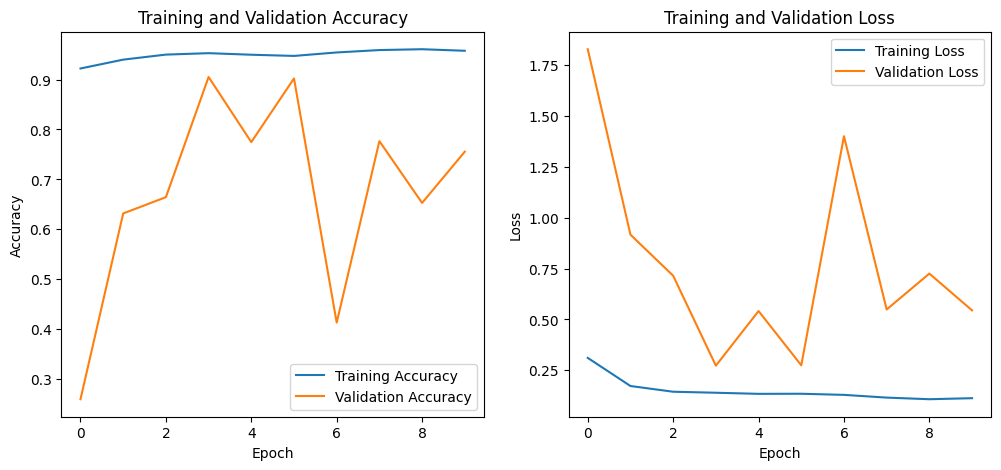

In [13]:
import matplotlib.pyplot as plt
# Create a figure with two subplots (1 row, 2 columns)
plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Testing the model on the same data

In [14]:
test_dir = 'data/chest_xray/test'
test_filepaths = []
test_labels = []

In [15]:
for category in categories:
    folder = os.path.join(test_dir, category)
    for fname in os.listdir(folder):
        test_filepaths.append(f"{category}/{fname}")
        test_labels.append(category)

In [16]:
test_df = pd.DataFrame({'Filename': test_filepaths, 'Label': test_labels})

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Loading training data from dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='Filename',
    y_col='Label',
    batch_size=32, # processing 32 images at a time
    shuffle=False, # shuffling data before the training
    class_mode='binary', # binary classification (NORMAL vs PNEUMONIA)
    target_size=(150, 150) # resizing images to 150x150 pixels
)

Found 624 validated image filenames belonging to 2 classes.


### Prediction step

In [19]:
pred_probs = model.predict(test_generator)
preds = (pred_probs > 0.5).astype(int).flatten()
true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
print(classification_report(true_labels, preds, target_names=class_labels))
print(confusion_matrix(true_labels, preds))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.28      0.43       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.72      0.67       624

[[ 66 168]
 [  4 386]]


In [20]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[]

In [21]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.7244 - loss: 1.0127
Final Test Accuracy: 72.44%


In [22]:
model.save('pneumonia_model.keras')